In [8]:
from scipy.constants import physical_constants
import matplotlib.pyplot as plt
import scipy.special as sp
import seaborn as sns
import numpy as np

In [9]:
def radial_function(n, l, r, a0):
    """ Compute the normalized radial part of the wavefunction using
    Laguerre polynomials and an exponential decay factor.
    Args:
        n (int): principal quantum number
        l (int): azimuthal quantum number
        r (numpy.ndarray): radial coordinate
        a0 (float): scaled Bohr radius
    Returns:
        numpy.ndarray: wavefunction radial component
    """

    laguerre = sp.genlaguerre(n - l - 1, 2 * l + 1)
    p = 2 * r / (n * a0)

    constant_factor = np.sqrt(
        ((2 / n * a0) ** 3 * (sp.factorial(n - l - 1))) /
        (2 * n * (sp.factorial(n + l)))
    )
    return constant_factor * np.exp(-p / 2) * (p ** l) * laguerre(p)

In [10]:
def angular_function(m, l, theta, phi):
    """ Compute the normalized angular part of the wavefunction using
    Legendre polynomials and a phase-shifting exponential factor.
    Args:
        m (int): magnetic quantum number
        l (int): azimuthal quantum number
        theta (numpy.ndarray): polar angle
        phi (int): azimuthal angle
    Returns:
        numpy.ndarray: wavefunction angular component
    """

    legendre = sp.lpmv(m, l, np.cos(theta))

    constant_factor = ((-1) ** m) * np.sqrt(
        ((2 * l + 1) * sp.factorial(l - np.abs(m))) /
        (4 * np.pi * sp.factorial(l + np.abs(m)))
    )
    return constant_factor * legendre * np.real(np.exp(1.j * m * phi))

In [11]:
def compute_wavefunction(n, l, m, a0_scale_factor):
    """ Compute the normalized wavefunction as a product
    of its radial and angular components.
    Args:
        n (int): principal quantum number
        l (int): azimuthal quantum number
        m (int): magnetic quantum number
        a0_scale_factor (float): Bohr radius scale factor
    Returns:
        numpy.ndarray: wavefunction
    """

    # Scale Bohr radius for effective visualization
    a0 = a0_scale_factor * physical_constants['Bohr radius'][0] * 1e+12

    # x-y grid to represent electron spatial distribution
    grid_extent = 480
    grid_resolution = 680
    z = x = np.linspace(-grid_extent, grid_extent, grid_resolution)
    z, x = np.meshgrid(z, x)

    # Use epsilon to avoid division by zero during angle calculations
    eps = np.finfo(float).eps

    # Ψnlm(r,θ,φ) = Rnl(r).Ylm(θ,φ)
    psi = radial_function(
        n, l, np.sqrt((x ** 2 + z ** 2)), a0
    ) * angular_function(
        m, l, np.arctan(x / (z + eps)), 0
    )
    return psi

In [12]:
def compute_probability_density(psi):
    """ Compute the probability density of a given wavefunction.
    Args:
        psi (numpy.ndarray): wavefunction
    Returns:
        numpy.ndarray: wavefunction probability density
    """
    return np.abs(psi) ** 2

In [13]:
def plot_wf_probability_density(n, l, m, a0_scale_factor, dark_theme=False, colormap='rocket'):
    """ Plot the probability density of the hydrogen
    atom's wavefunction for a given quantum state (n,l,m).
    Args:
        n (int): principal quantum number, determines the energy level and size of the orbital
        l (int): azimuthal quantum number, defines the shape of the orbital
        m (int): magnetic quantum number, defines the orientation of the orbital
        a0_scale_factor (float): Bohr radius scale factor
        dark_theme (bool): If True, uses a dark background for the plot, defaults to False
        colormap (str): Seaborn plot colormap, defaults to 'rocket'
    """

    # Quantum numbers validation
    if not isinstance(n, int) or n < 1:
        raise ValueError('n should be an integer satisfying the condition: n >= 1')
    if not isinstance(l, int) or not (0 <= l < n):
        raise ValueError('l should be an integer satisfying the condition: 0 <= l < n')
    if not isinstance(m, int) or not (-l <= m <= l):
        raise ValueError('m should be an integer satisfying the condition: -l <= m <= l')

    # Colormap validation
    try:
        sns.color_palette(colormap)
    except ValueError:
        raise ValueError(f'{colormap} is not a recognized Seaborn colormap.')

    # Configure plot aesthetics using matplotlib rcParams settings
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['xtick.major.width'] = 4
    plt.rcParams['ytick.major.width'] = 4
    plt.rcParams['xtick.major.size'] = 15
    plt.rcParams['ytick.major.size'] = 15
    plt.rcParams['xtick.labelsize'] = 30
    plt.rcParams['ytick.labelsize'] = 30
    plt.rcParams['axes.linewidth'] = 4

    fig, ax = plt.subplots(figsize=(16, 16.5))
    plt.subplots_adjust(top=0.82)
    plt.subplots_adjust(right=0.905)
    plt.subplots_adjust(left=-0.1)

    # Compute and visualize the wavefunction probability density
    psi = compute_wavefunction(n, l, m, a0_scale_factor)
    prob_density = compute_probability_density(psi)
    
    # Here we transpose the array to align the calculated z-x plane with Matplotlib's y-x imshow display
    im = ax.imshow(np.sqrt(prob_density).T, cmap=sns.color_palette(colormap, as_cmap=True))

    cbar = plt.colorbar(im, fraction=0.046, pad=0.03)
    cbar.set_ticks([])

    # Apply dark theme parameters
    if dark_theme:
        theme = 'dt'
        background_color = sorted(
            sns.color_palette(colormap, n_colors=100),
            key=lambda color: 0.2126 * color[0] + 0.7152 * color[1] + 0.0722 * color[2]
        )[0]
        plt.rcParams['text.color'] = '#dfdfdf'
        title_color = '#dfdfdf'
        fig.patch.set_facecolor(background_color)
        cbar.outline.set_visible(False)
        ax.tick_params(axis='x', colors='#c4c4c4')
        ax.tick_params(axis='y', colors='#c4c4c4')
        for spine in ax.spines.values():
            spine.set_color('#c4c4c4')

    else:  # Apply light theme parameters
        theme = 'lt'
        plt.rcParams['text.color'] = '#000000'
        title_color = '#000000'
        ax.tick_params(axis='x', colors='#000000')
        ax.tick_params(axis='y', colors='#000000')

    ax.set_title('Hydrogen Atom - Wavefunction Electron Density', 
                 pad=130, fontsize=44, loc='left', color=title_color)
    ax.text(0, 722, (
        r'$|\psi_{n \ell m}(r, \theta, \varphi)|^{2} ='
        r' |R_{n\ell}(r) Y_{\ell}^{m}(\theta, \varphi)|^2$'
    ), fontsize=36)
    ax.text(30, 615, r'$({0}, {1}, {2})$'.format(n, l, m), color='#dfdfdf', fontsize=42)
    ax.text(770, 140, 'Electron probability distribution', rotation='vertical', fontsize=40)
    ax.text(705, 700, 'Higher\nprobability', fontsize=24)
    ax.text(705, -60, 'Lower\nprobability', fontsize=24)
    ax.text(775, 590, '+', fontsize=34)
    ax.text(769, 82, '−', fontsize=34, rotation='vertical')
    ax.invert_yaxis()

    # Save and display the plot
    plt.savefig(f'({n},{l},{m})[{theme}].png')
    plt.show()

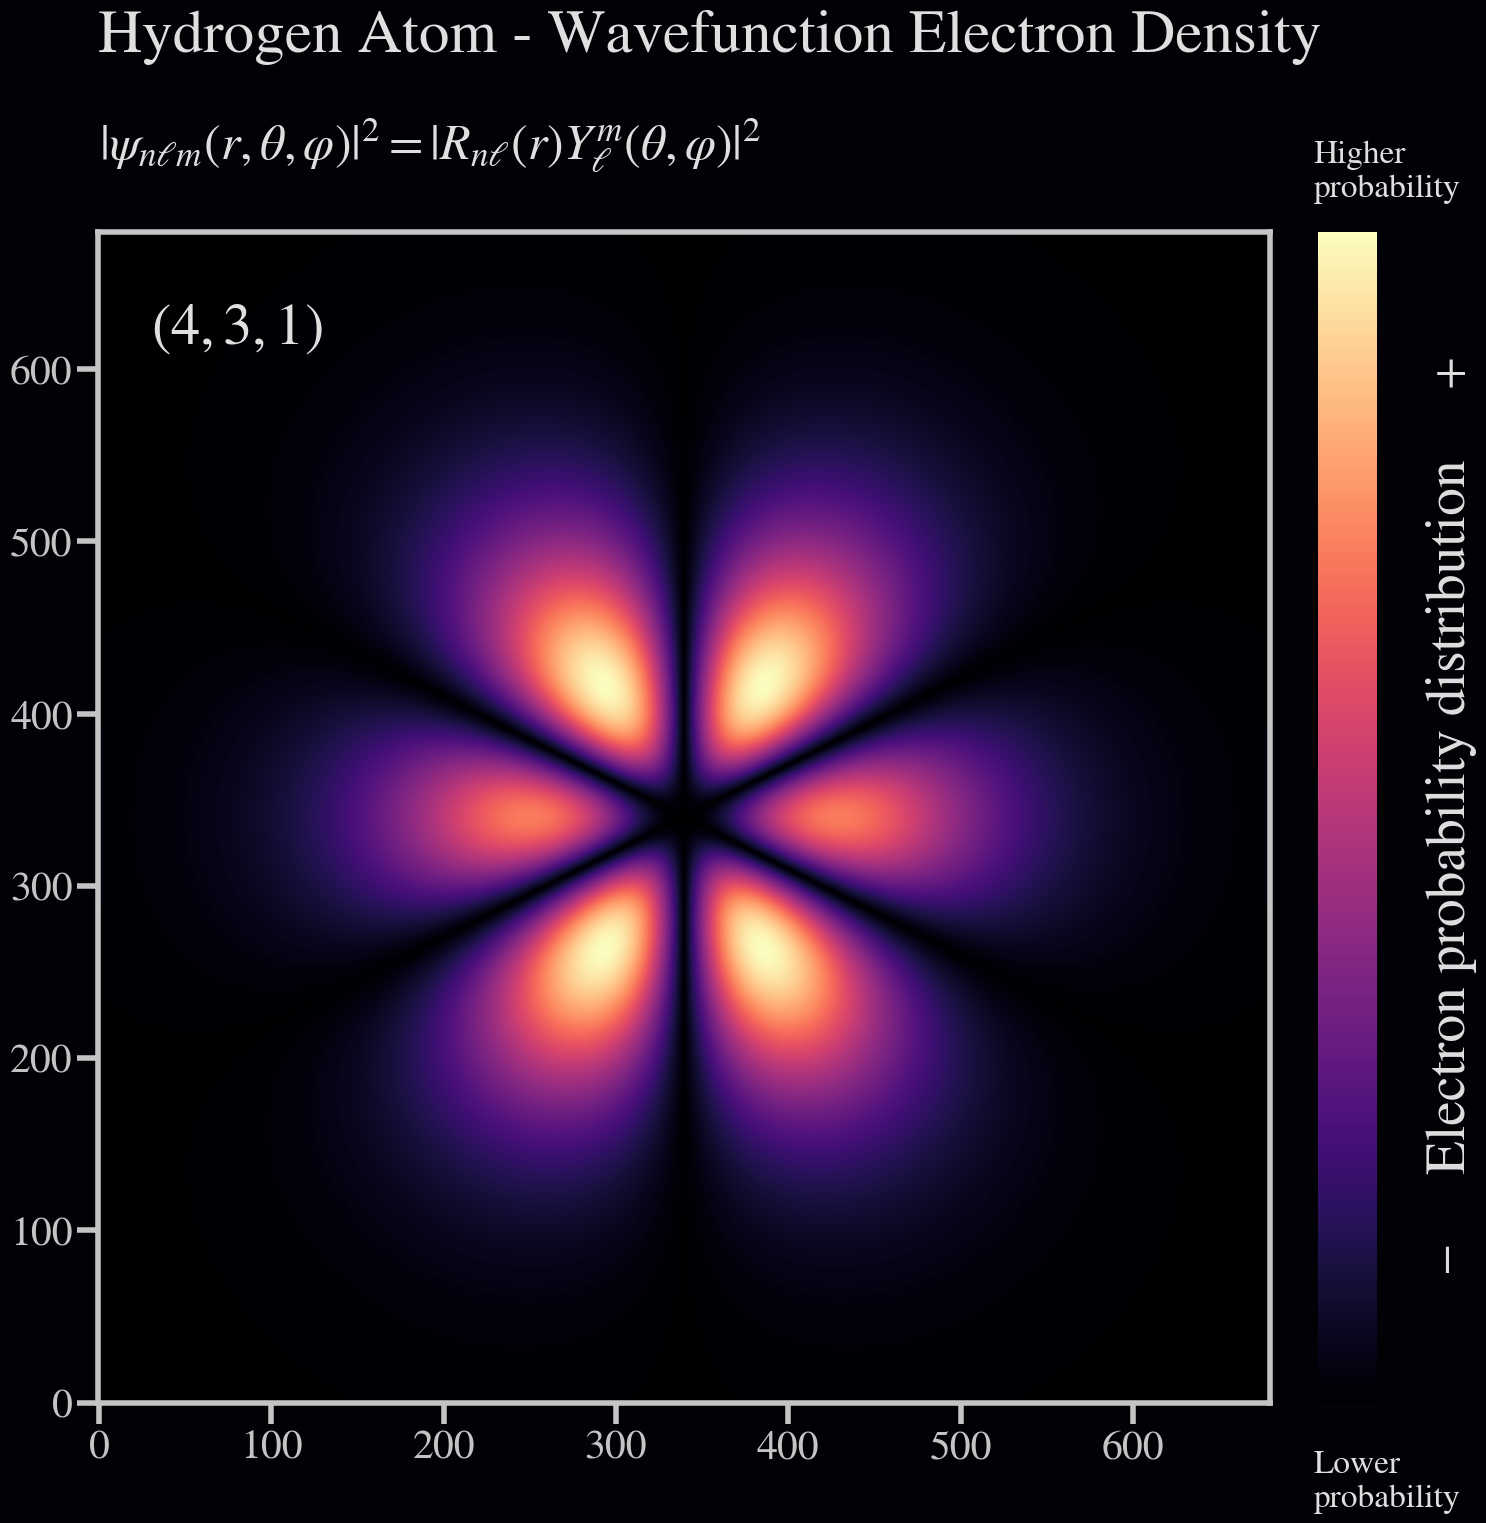

In [25]:
plot_wf_probability_density(4, 3, 1, 0.2, dark_theme=True, colormap='magma')